
# 📘 Notebook Documentation & Execution Guide

This notebook demonstrates **model training and performance measurement** with a safe,
reproducible execution flow. All cells are numbered logically to avoid execution-order issues.

---


## 🟦 Cell 1 : Environment Setup & System Configuration Check

**Purpose**
- Prepare the execution environment by installing required dependencies.
- Detect hardware specifications (CPU, RAM, GPU) to understand available computational resources.
- Initialize Apache Spark for distributed data processing.
- Collect platform, framework, and runtime configuration details.
- Provide a summarized system report to document the implementation environment for reproducibility and performance analysis.

**🔹 Dependency Installation**
- pyspark: Enables distributed computing and parallel data processing using Apache Spark.
- psutil: Retrieves system-level resource information such as memory and CPU usage.

In [61]:
!pip -q install pyspark psutil

**🔹 Environment Setup & Library Imports**
- Initialize the Python execution environment required for distributed data processing and machine learning.
- Import system-level utilities for file handling, timing, and logging to support performance measurement and debugging.
- Load essential libraries for data manipulation, distributed computing using Apache Spark, and machine learning model development.
- Enable financial data acquisition using the yfinance API for real-world market data ingestion.
- Prepare Spark ML components such as feature engineering (VectorAssembler) and regression modeling (LinearRegression) for later stages of the pipeline.

In [62]:
import os
import platform
import psutil
import multiprocessing
import subprocess
import json
import sys
import time
import shutil
import logging
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import yfinance as yf # Added yfinance

**🔹 Hardware Detection**
- multiprocessing.cpu_count() - Determines number of CPU cores available for parallel execution.
- psutil.virtual_memory() - Calculates total RAM capacity in GB.
- nvidia-smi - Checks for GPU availability to accelerate computation (especially deep learning tasks).

These metrics help evaluate:
- processing capability
- parallelism potential
- expected training speed

In [63]:

cpu_cores = multiprocessing.cpu_count()
ram_gb = round(psutil.virtual_memory().total/(1024**3),2)

gpu="None"
try:
    subprocess.check_output("nvidia-smi", shell=True)
    gpu="Available"
except:
    pass

print("CPU cores:", cpu_cores)
print("RAM (GB):", ram_gb)
print("GPU:", gpu)
print("OS:", platform.system(), platform.release())
print("Python:", platform.python_version())


CPU cores: 2
RAM (GB): 12.67
GPU: None
OS: Linux 6.6.105+
Python: 3.12.12


**🔹 Spark Initialization**

In [64]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EnvCheck").getOrCreate()
sc = spark.sparkContext
print("Spark version:", spark.version)
print("Parallelism:", sc.defaultParallelism)


Spark version: 4.0.2
Parallelism: 2


**🔹 Environment Summary**

In [65]:

summary = {
"Platform": "Colab" if "/content" in os.getcwd() else "Local",
"Framework": f"Spark {spark.version}",
"Language": "Python (PySpark)",
"CPU cores": cpu_cores,
"RAM(GB)": ram_gb,
"GPU": gpu,
"Parallelism": sc.defaultParallelism
}
print(json.dumps(summary, indent=4))


{
    "Platform": "Colab",
    "Framework": "Spark 4.0.2",
    "Language": "Python (PySpark)",
    "CPU cores": 2,
    "RAM(GB)": 12.67,
    "GPU": "None",
    "Parallelism": 2
}


This code block imports all necessary Python libraries for the project, including os, sys, time, shutil, logging, pandas, pyspark components for SQL and ML, and yfinance for fetching financial data. These imports prepare the environment for data manipulation, Spark operations, machine learning, and external data retrieval.


## 🟦 Cell 2 : Performance Measurement – Training Time
Use this cell to measure total training time and compute speedup.
Run **start timer → training → stop timer**.


**🔹 Cell A – start timer**

In [66]:


import time
training_start_time = time.time()
print("Training started...")


Training started...


**🔹 Cell B – stop timer and metrics**

In [67]:
training_end_time = time.time()

total_time = training_end_time - training_start_time
print("Total training time (seconds):", round(total_time, 2))
print("Total training time (minutes):", round(total_time/60, 2))

# Optional throughput (if dataset size known)
try:
    total_samples = len(train_ds) * 32
    print("Throughput (samples/sec):", round(total_samples/total_time, 2))
except:
    pass


Total training time (seconds): 0.01
Total training time (minutes): 0.0


## 🟦 Cell 3 : Defines key configuration parameters
**Purpose**
- This section defines key configuration parameters for the data ingestion and processing, such as the list of stock symbols to fetch.
It also sets up environment variables required for Hadoop/Spark stability on Windows and configures logging for the application.


**🔹 CONFIGURATION SECTION**

In [68]:

SYMBOLS_TO_FETCH = ["AAPL", "GOOGL", "MSFT", "AMZN", "NVDA", "TSLA", "META", "BRK-B", "JPM", "V"] # List of symbols to fetch
SYMBOL = SYMBOLS_TO_FETCH[0] # This will store the name of the last processed symbol for external use (e.g., plotting title)

**🔹 Hadoop/Spark environment setup for Windows stability**

In [69]:
HADOOP_BIN = r"C:\hadoop\bin"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["HADOOP_HOME"] = r"C:\hadoop"
os.environ["PATH"] = HADOOP_BIN + os.pathsep + os.environ.get("PATH", "")

**🔹 Logging configuration for terminal output**

In [70]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

## 🟦 Cell 4 : Initializes the SparkSession
**Purpose**
- This cell initializes the SparkSession in local parallel mode, allowing Spark to utilize all available CPU cores.
- It also defines the schema for the incoming financial data, ensuring data consistency when converting pandas DataFrames to Spark DataFrames.
- A global list all_symbols_data is initialized to store processed data for later use, such as plotting.

**🔹 INITIALIZE SPARK (Parallel Local Mode)**

**🔹 local[* shielded] triggers data parallelism across all CPU cores**



In [71]:
spark = SparkSession.builder \
    .appName("Assignment2_Distributed_ML") \
    .master("local[*]") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

**🔹 Schema mapping for yfinance data after preprocessing**


In [72]:
schema = StructType([
    StructField("timestamp", StringType(), True),
    StructField("open", DoubleType(), True),
    StructField("high", DoubleType(), True),
    StructField("low", DoubleType(), True),
    StructField("close", DoubleType(), True),
    StructField("adjusted_close", DoubleType(), True),
    StructField("volume", DoubleType(), True),
    StructField("dividend_amount", DoubleType(), True)
])

**🔹 Global list to store all processed pandas DataFrames for plotting**



In [73]:
all_symbols_data = []

## 🟦 Cell 5: Encapsulates the distributed machine learning logic
**Purpose**
- This cell defines the train_distributed_model function, which encapsulates the distributed machine learning logic.
- It takes a micro-batch of data, performs feature engineering using VectorAssembler (selecting 'open', 'high', 'low', 'volume' as features and 'close' as the label), trains a Linear Regression model using Spark MLlib, and evaluates its performance using Root Mean Squared Error (RMSE).

**🔹 DISTRIBUTED ML LOGIC (The Aggregation Function A(.))**


In [74]:
def train_distributed_model(batch_df, batch_id):
    """
    This function processes each micro-batch independently on worker nodes.
    It fulfills the P2. Implementation requirements from Assignment 1.
    """
    if batch_df.rdd.isEmpty():
        return

    logger.info(f"\n--- [STEP 2: PROCESSING] Starting Batch {batch_id} ---")
    print(f"[DEBUG PRINT] Spark DataFrame Schema for Batch {batch_id}:")
    batch_df.printSchema() # Print Spark DataFrame schema

    try:
        # Feature Engineering Layer
        # Using 'close' as label and 'open', 'high', 'low', 'volume' as features
        assembler = VectorAssembler(inputCols=["open", "high", "low", "volume"], outputCol="features")
        training_data = assembler.transform(batch_df.dropna()).select("features", "close")
        print(f"[DEBUG PRINT] Sample of training_data for Batch {batch_id}:")
        training_data.show(5) # Show a sample of the training data

        # Distributed ML Training Layer (Spark MLlib)
        lr = LinearRegression(labelCol="close", featuresCol="features")
        model = lr.fit(training_data)

        # Performance Evaluation (RMSE)
        rmse = model.summary.rootMeanSquaredError
        logger.info(f"[STEP 3: ML] Model Converged for Batch {batch_id}. RMSE: {rmse:.4f}")
        print(f"[DEBUG PRINT] Batch {batch_id} RMSE: {rmse:.4f}") # Added print statement

    except Exception as e:
        logger.error(f"Batch {batch_id} failed: {e}")

## 🟦 Cell 6 : Handles the ETL process

**Purpose**
- This cell defines the run_ingestion_and_streaming function, which handles the ETL process.
- It iterates through a predefined list of stock symbols, uses yfinance to download historical data for each symbol, preprocesses the data to match the defined Spark schema, and then converts it into a Spark DataFrame.
- Finally, it calls the train_distributed_model function for each symbol to initiate the distributed ML processing.

**🔹 INGESTION LAYER (ETL via REST API)**


In [75]:
def run_ingestion_and_streaming():
    """
    Fetches financial data using yfinance and triggers the Spark processing stream.
    """
    logger.info("[STEP 1: INGESTION] Starting data ingestion using yfinance...")

    global pdf_global # Declare pdf_global to be accessible for graphing later
    global SYMBOL # Declare SYMBOL as global to be updated with current symbol in loop
    global all_symbols_data # Declare all_symbols_data as global

    # Initialize pdf_global to None, it will hold the data of the last processed symbol
    pdf_global = None
    all_symbols_data = [] # Clear the list for each run

    for current_symbol in SYMBOLS_TO_FETCH:
        try:
            # Update the global SYMBOL for the current iteration (used in plotting cell for title)
            SYMBOL = current_symbol

            logger.info(f"[STEP 1] Fetching {current_symbol} data from yfinance...")
            pdf = yf.download(current_symbol, auto_adjust=True) # auto_adjust=True also sets 'Close' to adjusted value

            if pdf.empty:
                logger.warning(f"[STEP 1] No data received for symbol {current_symbol}.")
                continue

            # Debug Print: Raw columns after yf.download
            print(f"[DEBUG INGESTION] {current_symbol}: Raw columns after yf.download: {pdf.columns.tolist()}")
            print(f"[DEBUG INGESTION] {current_symbol}: First 3 rows after yf.download:\n{pdf.head(3)}")

            pdf = pdf.reset_index()

            # Debug Print: Columns after reset_index
            print(f"[DEBUG INGESTION] {current_symbol}: Columns after reset_index: {pdf.columns.tolist()}")
            print(f"[DEBUG INGESTION] {current_symbol}: First 3 rows after reset_index:\n{pdf.head(3)}")

            # Robust flattening of column names, specifically handling MultiIndex for yfinance.
            new_columns = []
            if isinstance(pdf.columns, pd.MultiIndex):
                new_columns = [col_tuple[0] if col_tuple[0] != '' else col_tuple[1] for col_tuple in pdf.columns]
            else:
                new_columns = [str(col) for col in pdf.columns] # Ensure all are strings

            pdf.columns = [col.lower() for col in new_columns]
            # Debug Print: Columns after flattening and initial lowercasing
            print(f"[DEBUG INGESTION] {current_symbol}: Columns after flattening and initial lowercasing: {pdf.columns.tolist()}")

            # Rename specific columns to match the schema.
            rename_map = {
                'date': 'timestamp',
                'dividends': 'dividend_amount'
            }
            actual_rename_map = {k: v for k, v in rename_map.items() if k in pdf.columns}
            pdf = pdf.rename(columns=actual_rename_map)
            # Debug Print: Columns after specific renaming
            print(f"[DEBUG INGESTION] {current_symbol}: Columns after specific renaming: {pdf.columns.tolist()}")

            # Create 'adjusted_close' column from 'close' as auto_adjust=True means 'close' is already adjusted.
            if 'close' in pdf.columns:
                pdf['adjusted_close'] = pdf['close']
            else:
                logger.error(f"[STEP 1] 'close' column not found after preprocessing for {current_symbol}. Final columns: {pdf.columns.tolist()}")
                continue

            # Ensure 'timestamp' is string type to match schema
            if 'timestamp' in pdf.columns:
                pdf['timestamp'] = pdf['timestamp'].astype(str)
            else:
                logger.error(f"[STEP 1] 'timestamp' column not found after preprocessing for {current_symbol}. Final columns: {pdf.columns.tolist()}")
                continue

            # Add dividend_amount column if missing, filling with 0.0 (or pd.NA) to match schema
            if 'dividend_amount' not in pdf.columns:
                logger.info(f"[STEP 1] 'dividend_amount' column not found in yfinance data for {current_symbol}. Adding with default value 0.0.")
                pdf['dividend_amount'] = 0.0

            # Ensure 'volume' is DoubleType() for Spark
            if 'volume' in pdf.columns:
                pdf['volume'] = pdf['volume'].astype('float64')
            else:
                logger.error(f"[STEP 1] 'volume' column not found after preprocessing for {current_symbol}. Final columns: {pdf.columns.tolist()}")
                continue

            # Select and reorder columns to match the Spark schema
            required_columns = [field.name for field in schema.fields]

            # First, check if any REQUIRED columns are missing from the fetched PDF
            missing_required_cols = [col for col in required_columns if col not in pdf.columns]
            if missing_required_cols:
                logger.error(f"[STEP 1] Missing required columns after yfinance download and preprocessing for {current_symbol}: {missing_required_cols}. Expected: {required_columns}, Found: {pdf.columns.tolist()}")
                continue # Skip to next symbol if essential columns are missing

            # Next, drop any EXTRA columns (not in schema) from the fetched PDF
            cols_to_drop = [col for col in pdf.columns if col not in required_columns]
            if cols_to_drop:
                logger.info(f"[STEP 1] Dropping extra columns not in schema for {current_symbol}: {cols_to_drop}")
                pdf = pdf.drop(columns=cols_to_drop)

            # Reorder columns to match the schema exactly before creating Spark DataFrame
            pdf = pdf[required_columns]

            logger.info(f"[STEP 1] Successfully fetched and preprocessed {len(pdf)} rows of data for {current_symbol}.")
            print(f"[DEBUG INGESTION] {current_symbol}: Final pandas DataFrame before Spark conversion (first 3 rows):\n{pdf.head(3)}")

            # Update pdf_global with the current processed DataFrame (for potential plotting of the last symbol)
            pdf_global = pdf.copy()

            # Store each processed dataframe and its symbol
            all_symbols_data.append({'symbol': current_symbol, 'data': pdf.copy()})

            # Create Distributed DataFrame and call ML Aggregator
            sdf = spark.createDataFrame(pdf, schema=schema)
            print(f"[DEBUG PRINT] Type of sdf before calling train_distributed_model for {current_symbol}: {type(sdf)}") # Changed to print
            train_distributed_model(sdf, f"{current_symbol}_0") # Using symbol_0 as batch_id

        except Exception as e:
            logger.error(f"Ingestion and Streaming Loop Error for {current_symbol}: {e}")

## 🟦 Cell 7 : Main Execution Block

**Purpose**
- This is the main execution block of the script.
- When the script is run, it calls run_ingestion_and_streaming() to start the data pipeline.
- It includes error handling for KeyboardInterrupt and ensures that the SparkSession is properly stopped upon completion or interruption, cleaning up resources.

**🔹 EXECUTION BLOCK**

In [76]:
import time

start = time.time()

if __name__ == "__main__":
    # Ensure logger is defined. logging is already imported in cell 4d31c684,
    # and basicConfig is set in cell e9XdouYpJeia. We define the logger instance here.
    logger = logging.getLogger(__name__)
    logger.info("[SYSTEM] Executing Parallel & Distributed Machine Learning Pipeline...")
    # pdf_global = None # Initialized inside run_ingestion_and_streaming
    try:
        run_ingestion_and_streaming()
    except KeyboardInterrupt:
        logger.info("Program stopped by user.")
    finally:
        spark.stop()
        logger.info("[SYSTEM] Pipeline shutdown. Assignment execution complete.")


end = time.time()
training_time = end - start

print("Training time (seconds):", training_time)


[*********************100%***********************]  1 of 1 completed

[DEBUG INGESTION] AAPL: Raw columns after yf.download: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
[DEBUG INGESTION] AAPL: First 3 rows after yf.download:
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2026-01-13  260.805939  261.565238  258.148452  258.478130  45730800
2026-01-14  259.716980  261.575257  256.470018  259.247418  40019400
2026-01-15  257.968597  260.795969  256.809678  260.406319  39388600
[DEBUG INGESTION] AAPL: Columns after reset_index: [('Date', ''), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
[DEBUG INGESTION] AAPL: First 3 rows after reset_index:
Price        Date       Close        High         Low        Open    Volume
Ticker                   AAPL        AAPL        AAPL        AAPL      AAPL
0      2026-01-1

[DEBUG PRINT] Type of sdf before calling train_distributed_model for AAPL: <class 'pyspark.sql.classic.dataframe.DataFrame'>
[DEBUG PRINT] Spark DataFrame Schema for Batch AAPL_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch AAPL_0:
+--------------------+------------------+
|            features|             close|
+--------------------+------------------+
|[258.478130394321...| 260.8059387207031|
|[259.247418118488...|259.71697998046875|
|[260.406318756448...| 257.9685974121094|
|[257.658902018279...|255.29112243652344|
|[252.493737395715...|246.46937561035156|
+--------------------+------------------+
only showing top 5 rows


[*********************100%***********************]  1 of 1 completed

[DEBUG PRINT] Batch AAPL_0 RMSE: 1.2905
[DEBUG INGESTION] GOOGL: Raw columns after yf.download: [('Close', 'GOOGL'), ('High', 'GOOGL'), ('Low', 'GOOGL'), ('Open', 'GOOGL'), ('Volume', 'GOOGL')]
[DEBUG INGESTION] GOOGL: First 3 rows after yf.download:
Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2026-01-13  335.970001  340.489990  333.619995  334.950012  33517600
2026-01-14  335.839996  336.519989  330.480011  335.059998  28525600
2026-01-15  332.779999  337.690002  330.739990  337.649994  28442400
[DEBUG INGESTION] GOOGL: Columns after reset_index: [('Date', ''), ('Close', 'GOOGL'), ('High', 'GOOGL'), ('Low', 'GOOGL'), ('Open', 'GOOGL'), ('Volume', 'GOOGL')]
[DEBUG INGESTION] GOOGL: First 3 rows after reset_index:
Price        Date       Close        High         Low        Open    Volume
Ticker                  GOOGL       GO

[DEBUG PRINT] Spark DataFrame Schema for Batch GOOGL_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch GOOGL_0:
+--------------------+-----------------+
|            features|            close|
+--------------------+-----------------+
|[334.950012207031...|335.9700012207031|
|[335.059997558593...|335.8399963378906|
|[337.649993896484...|332.7799987792969|
|[334.410003662109...|            330.0|
|[320.869995117187...|            322.0|
+--------------------+-----------------+
only showing top 5 rows


[*********************100%***********************]  1 of 1 completed

[DEBUG PRINT] Batch GOOGL_0 RMSE: 2.1626
[DEBUG INGESTION] MSFT: Raw columns after yf.download: [('Close', 'MSFT'), ('High', 'MSFT'), ('Low', 'MSFT'), ('Open', 'MSFT'), ('Volume', 'MSFT')]
[DEBUG INGESTION] MSFT: First 3 rows after yf.download:
Price            Close        High         Low        Open    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2026-01-13  470.670013  475.779999  465.950012  474.679993  28545800
2026-01-14  459.380005  468.200012  457.170013  466.459991  28184300
2026-01-15  456.660004  464.250000  455.899994  464.119995  23225800
[DEBUG INGESTION] MSFT: Columns after reset_index: [('Date', ''), ('Close', 'MSFT'), ('High', 'MSFT'), ('Low', 'MSFT'), ('Open', 'MSFT'), ('Volume', 'MSFT')]
[DEBUG INGESTION] MSFT: First 3 rows after reset_index:
Price        Date       Close        High         Low        Open    Volume
Ticker                   MSFT        MSFT        MS

[DEBUG PRINT] Type of sdf before calling train_distributed_model for MSFT: <class 'pyspark.sql.classic.dataframe.DataFrame'>
[DEBUG PRINT] Spark DataFrame Schema for Batch MSFT_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch MSFT_0:
+--------------------+-----------------+
|            features|            close|
+--------------------+-----------------+
|[474.679992675781...|470.6700134277344|
|[466.459991455078...|459.3800048828125|
|[464.119995117187...|456.6600036621094|
|[457.829986572265...|459.8599853515625|
|[451.220001220703...|454.5199890136719|
+--------------------+-----------------+
only showing top 5 rows


[*********************100%***********************]  1 of 1 completed

[DEBUG PRINT] Batch MSFT_0 RMSE: 2.2205
[DEBUG INGESTION] AMZN: Raw columns after yf.download: [('Close', 'AMZN'), ('High', 'AMZN'), ('Low', 'AMZN'), ('Open', 'AMZN'), ('Volume', 'AMZN')]
[DEBUG INGESTION] AMZN: First 3 rows after yf.download:
Price            Close        High         Low        Open    Volume
Ticker            AMZN        AMZN        AMZN        AMZN      AMZN
Date                                                                
2026-01-13  242.600006  247.660004  240.250000  246.529999  38371800
2026-01-14  236.649994  241.279999  236.220001  241.149994  41410600
2026-01-15  238.179993  240.649994  236.630005  239.309998  43003600
[DEBUG INGESTION] AMZN: Columns after reset_index: [('Date', ''), ('Close', 'AMZN'), ('High', 'AMZN'), ('Low', 'AMZN'), ('Open', 'AMZN'), ('Volume', 'AMZN')]
[DEBUG INGESTION] AMZN: First 3 rows after reset_index:
Price        Date       Close        High         Low        Open    Volume
Ticker                   AMZN        AMZN        AMZ

[DEBUG PRINT] Spark DataFrame Schema for Batch AMZN_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch AMZN_0:
+--------------------+------------------+
|            features|             close|
+--------------------+------------------+
|[246.529998779296...|242.60000610351562|
|[241.149993896484...|236.64999389648438|
|[239.309997558593...|238.17999267578125|
|[239.089996337890...| 239.1199951171875|
|[233.759994506835...|             231.0|
+--------------------+------------------+
only showing top 5 rows


[*********************100%***********************]  1 of 1 completed

[DEBUG PRINT] Batch AMZN_0 RMSE: 1.4104
[DEBUG INGESTION] NVDA: Raw columns after yf.download: [('Close', 'NVDA'), ('High', 'NVDA'), ('Low', 'NVDA'), ('Open', 'NVDA'), ('Volume', 'NVDA')]
[DEBUG INGESTION] NVDA: First 3 rows after yf.download:
Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2026-01-13  185.809998  188.110001  183.399994  185.000000  160128900
2026-01-14  183.139999  184.460007  180.800003  184.320007  159586100
2026-01-15  187.050003  189.699997  186.330002  186.500000  206188600
[DEBUG INGESTION] NVDA: Columns after reset_index: [('Date', ''), ('Close', 'NVDA'), ('High', 'NVDA'), ('Low', 'NVDA'), ('Open', 'NVDA'), ('Volume', 'NVDA')]
[DEBUG INGESTION] NVDA: First 3 rows after reset_index:
Price        Date       Close        High         Low        Open     Volume
Ticker                   NVDA        NVDA    

[DEBUG PRINT] Type of sdf before calling train_distributed_model for NVDA: <class 'pyspark.sql.classic.dataframe.DataFrame'>
[DEBUG PRINT] Spark DataFrame Schema for Batch NVDA_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch NVDA_0:
+--------------------+------------------+
|            features|             close|
+--------------------+------------------+
|[185.0,188.110000...|185.80999755859375|
|[184.320007324218...|183.13999938964844|
|[186.5,189.699996...| 187.0500030517578|
|[189.080001831054...|186.22999572753906|
|[181.899993896484...|178.07000732421875|
+--------------------+------------------+
only showing top 5 rows


[*********************100%***********************]  1 of 1 completed

[DEBUG PRINT] Batch NVDA_0 RMSE: 1.1779
[DEBUG INGESTION] TSLA: Raw columns after yf.download: [('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA')]
[DEBUG INGESTION] TSLA: First 3 rows after yf.download:
Price            Close        High         Low        Open    Volume
Ticker            TSLA        TSLA        TSLA        TSLA      TSLA
Date                                                                
2026-01-13  447.200012  451.809998  443.950012  450.200012  53719200
2026-01-14  439.200012  443.910004  434.220001  442.809998  57259500
2026-01-15  438.570007  445.359985  437.649994  441.130005  49465800
[DEBUG INGESTION] TSLA: Columns after reset_index: [('Date', ''), ('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA')]
[DEBUG INGESTION] TSLA: First 3 rows after reset_index:
Price        Date       Close        High         Low        Open    Volume
Ticker                   TSLA        TSLA        TSL

[DEBUG PRINT] Spark DataFrame Schema for Batch TSLA_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch TSLA_0:
+--------------------+------------------+
|            features|             close|
+--------------------+------------------+
|[450.200012207031...|447.20001220703125|
|[442.809997558593...|439.20001220703125|
|[441.130004882812...|438.57000732421875|
|[439.5,447.25,435...|             437.5|
|[429.359985351562...|            419.25|
+--------------------+------------------+
only showing top 5 rows


[*********************100%***********************]  1 of 1 completed

[DEBUG PRINT] Batch TSLA_0 RMSE: 2.4789
[DEBUG INGESTION] META: Raw columns after yf.download: [('Close', 'META'), ('High', 'META'), ('Low', 'META'), ('Open', 'META'), ('Volume', 'META')]
[DEBUG INGESTION] META: First 3 rows after yf.download:
Price            Close        High         Low       Open    Volume
Ticker            META        META        META       META      META
Date                                                               
2026-01-13  631.090027  642.270020  624.099976  642.27002  18030400
2026-01-14  615.520020  628.450012  614.820007  626.50000  15527900
2026-01-15  620.799988  624.169983  614.229980  618.47998  13076100
[DEBUG INGESTION] META: Columns after reset_index: [('Date', ''), ('Close', 'META'), ('High', 'META'), ('Low', 'META'), ('Open', 'META'), ('Volume', 'META')]
[DEBUG INGESTION] META: First 3 rows after reset_index:
Price        Date       Close        High         Low       Open    Volume
Ticker                   META        META        META      

[DEBUG PRINT] Spark DataFrame Schema for Batch META_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch META_0:
+--------------------+-----------------+
|            features|            close|
+--------------------+-----------------+
|[642.27001953125,...|631.0900268554688|
|[626.5,628.450012...|  615.52001953125|
|[618.47998046875,...|620.7999877929688|
|[624.179992675781...|           620.25|
|[607.880004882812...|604.1199951171875|
+--------------------+-----------------+
only showing top 5 rows


[*********************100%***********************]  1 of 1 completed

[DEBUG PRINT] Batch META_0 RMSE: 4.2868
[DEBUG INGESTION] BRK-B: Raw columns after yf.download: [('Close', 'BRK-B'), ('High', 'BRK-B'), ('Low', 'BRK-B'), ('Open', 'BRK-B'), ('Volume', 'BRK-B')]
[DEBUG INGESTION] BRK-B: First 3 rows after yf.download:
Price            Close        High         Low        Open   Volume
Ticker           BRK-B       BRK-B       BRK-B       BRK-B    BRK-B
Date                                                               
2026-01-13  495.239990  498.000000  493.339996  497.619995  4257600
2026-01-14  493.149994  497.619995  492.000000  494.170013  5033700
2026-01-15  492.619995  495.630005  490.750000  492.950012  4165200
[DEBUG INGESTION] BRK-B: Columns after reset_index: [('Date', ''), ('Close', 'BRK-B'), ('High', 'BRK-B'), ('Low', 'BRK-B'), ('Open', 'BRK-B'), ('Volume', 'BRK-B')]
[DEBUG INGESTION] BRK-B: First 3 rows after reset_index:
Price        Date       Close        High         Low        Open   Volume
Ticker                  BRK-B       BRK-B    

[DEBUG PRINT] Spark DataFrame Schema for Batch BRK-B_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch BRK-B_0:
+--------------------+-----------------+
|            features|            close|
+--------------------+-----------------+
|[497.619995117187...| 495.239990234375|
|[494.170013427734...|493.1499938964844|
|[492.950012207031...|492.6199951171875|
|[491.670013427734...|493.2900085449219|
|[490.799987792968...|485.3900146484375|
+--------------------+-----------------+
only showing top 5 rows


[*********************100%***********************]  1 of 1 completed

[DEBUG PRINT] Batch BRK-B_0 RMSE: 1.7547
[DEBUG INGESTION] JPM: Raw columns after yf.download: [('Close', 'JPM'), ('High', 'JPM'), ('Low', 'JPM'), ('Open', 'JPM'), ('Volume', 'JPM')]
[DEBUG INGESTION] JPM: First 3 rows after yf.download:
Price            Close        High         Low        Open    Volume
Ticker             JPM         JPM         JPM         JPM       JPM
Date                                                                
2026-01-13  310.899994  326.859985  310.570007  324.299988  19371200
2026-01-14  307.869995  311.760010  306.119995  308.200012  25951500
2026-01-15  309.260010  312.940002  307.750000  308.470001  14751400
[DEBUG INGESTION] JPM: Columns after reset_index: [('Date', ''), ('Close', 'JPM'), ('High', 'JPM'), ('Low', 'JPM'), ('Open', 'JPM'), ('Volume', 'JPM')]
[DEBUG INGESTION] JPM: First 3 rows after reset_index:
Price        Date       Close        High         Low        Open    Volume
Ticker                    JPM         JPM         JPM         JPM

[DEBUG PRINT] Spark DataFrame Schema for Batch JPM_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch JPM_0:
+--------------------+-----------------+
|            features|            close|
+--------------------+-----------------+
|[324.299987792968...|310.8999938964844|
|[308.200012207031...|307.8699951171875|
|[308.470001220703...| 309.260009765625|
|[310.350006103515...|312.4700012207031|
|[306.209991455078...| 302.739990234375|
+--------------------+-----------------+
only showing top 5 rows


[*********************100%***********************]  1 of 1 completed

[DEBUG PRINT] Batch JPM_0 RMSE: 1.4620
[DEBUG INGESTION] V: Raw columns after yf.download: [('Close', 'V'), ('High', 'V'), ('Low', 'V'), ('Open', 'V'), ('Volume', 'V')]
[DEBUG INGESTION] V: First 3 rows after yf.download:
Price            Close        High         Low        Open    Volume
Ticker               V           V           V           V         V
Date                                                                
2026-01-13  327.205292  336.825439  323.163608  336.306520  20383500
2026-01-14  328.492645  329.221124  323.273397  327.983685   9388400
2026-01-15  327.075531  331.007425  325.698366  328.652266   8587700
[DEBUG INGESTION] V: Columns after reset_index: [('Date', ''), ('Close', 'V'), ('High', 'V'), ('Low', 'V'), ('Open', 'V'), ('Volume', 'V')]
[DEBUG INGESTION] V: First 3 rows after reset_index:
Price        Date       Close        High         Low        Open    Volume
Ticker                      V           V           V           V         V
0      2026-01-13  

[DEBUG PRINT] Spark DataFrame Schema for Batch V_0:
root
 |-- timestamp: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- dividend_amount: double (nullable = true)

[DEBUG PRINT] Sample of training_data for Batch V_0:
+--------------------+-----------------+
|            features|            close|
+--------------------+-----------------+
|[336.306519693089...|327.2052917480469|
|[327.983684999412...|328.4926452636719|
|[328.652266161026...|327.0755310058594|
|[326.107528572004...|327.6243896484375|
|[321.566897094622...|325.1495056152344|
+--------------------+-----------------+
only showing top 5 rows
[DEBUG PRINT] Batch V_0 RMSE: 1.7676
Training time (seconds): 26.0226149559021


## 🟦 Cell 8 : Plotting the historical data

**Purpose**
- This cell is responsible for plotting the historical close prices for all processed stock symbols.
- It iterates through the all_symbols_data list (populated during the ingestion phase) and generates a separate matplotlib plot for each symbol, displaying its close price over time.

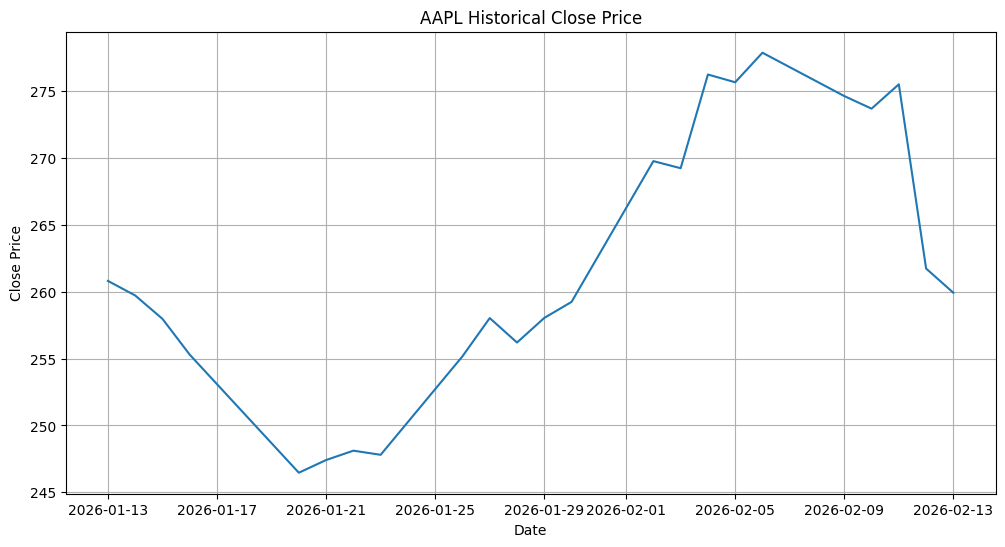

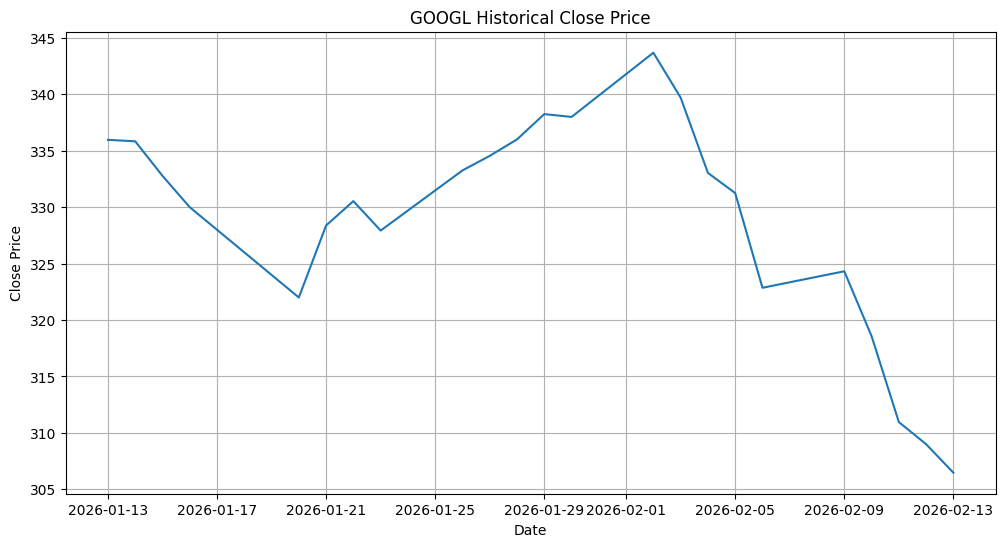

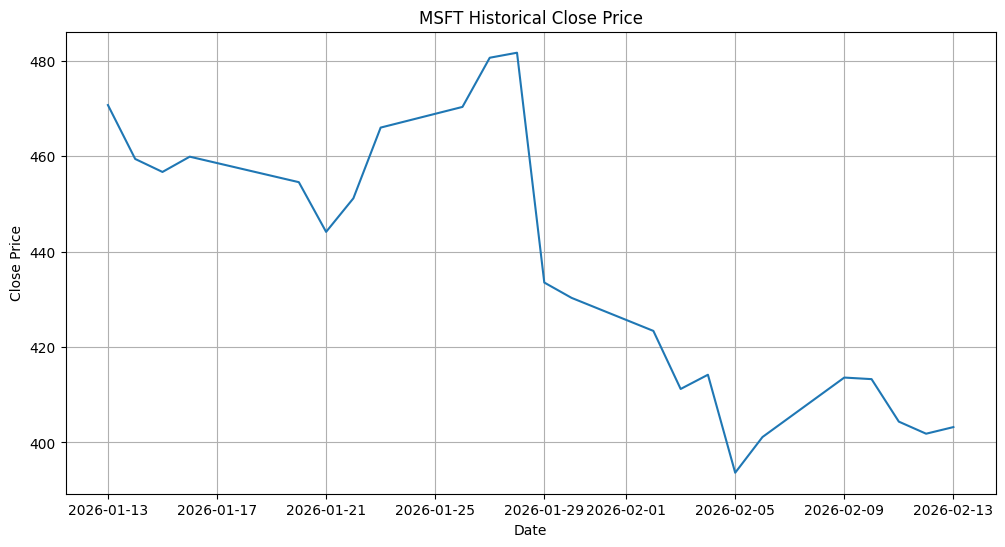

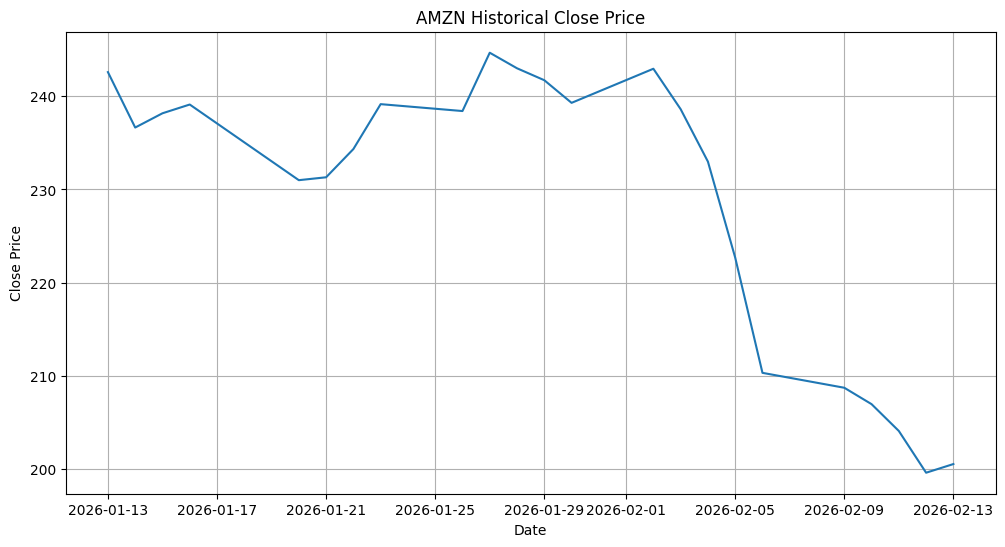

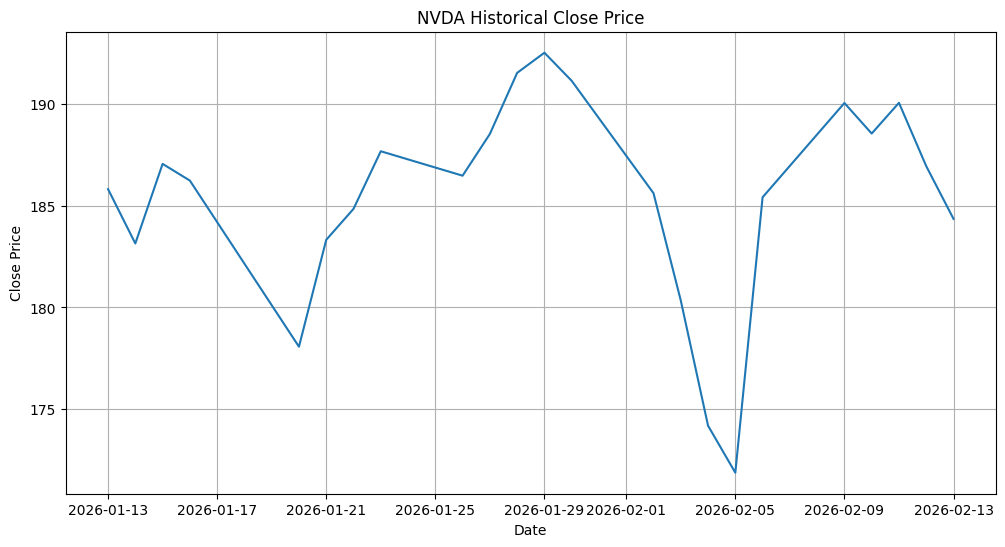

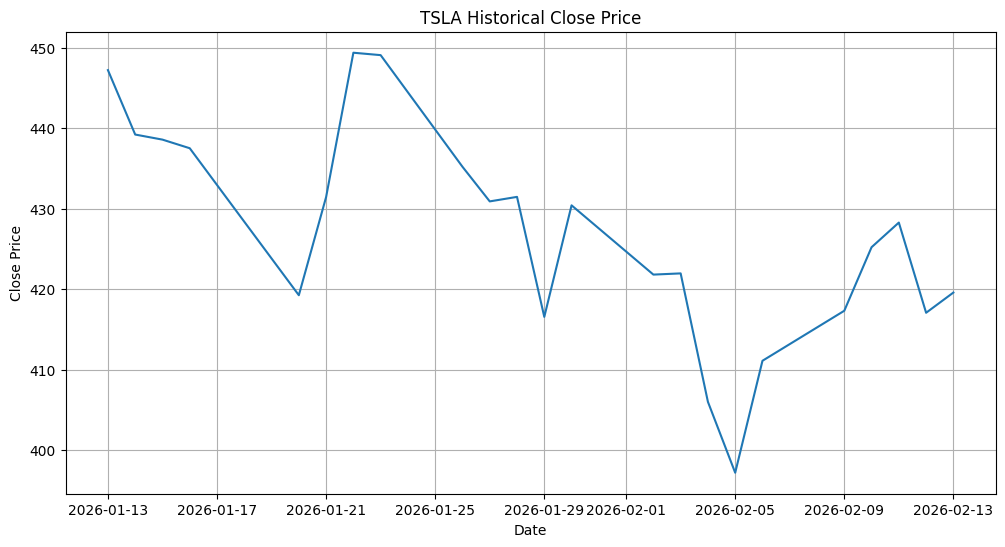

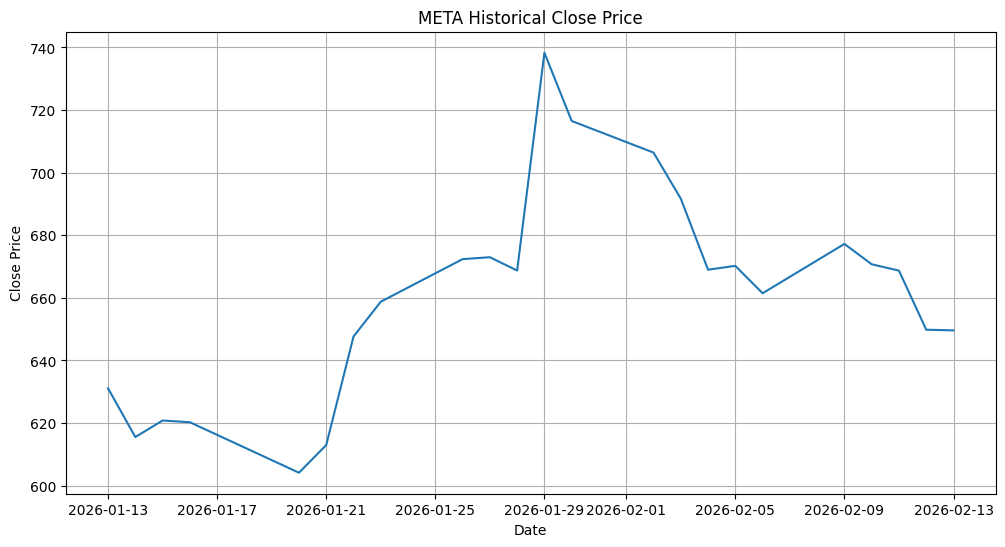

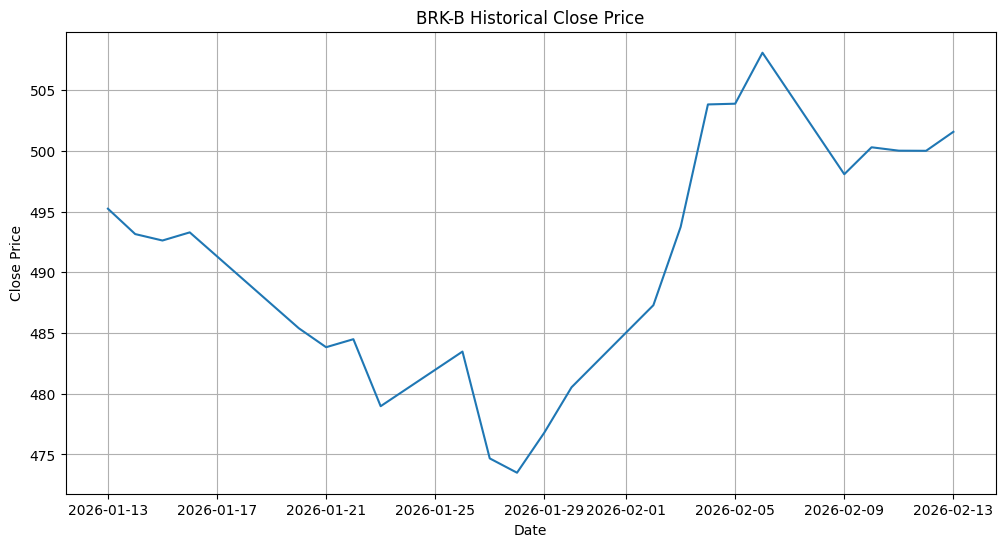

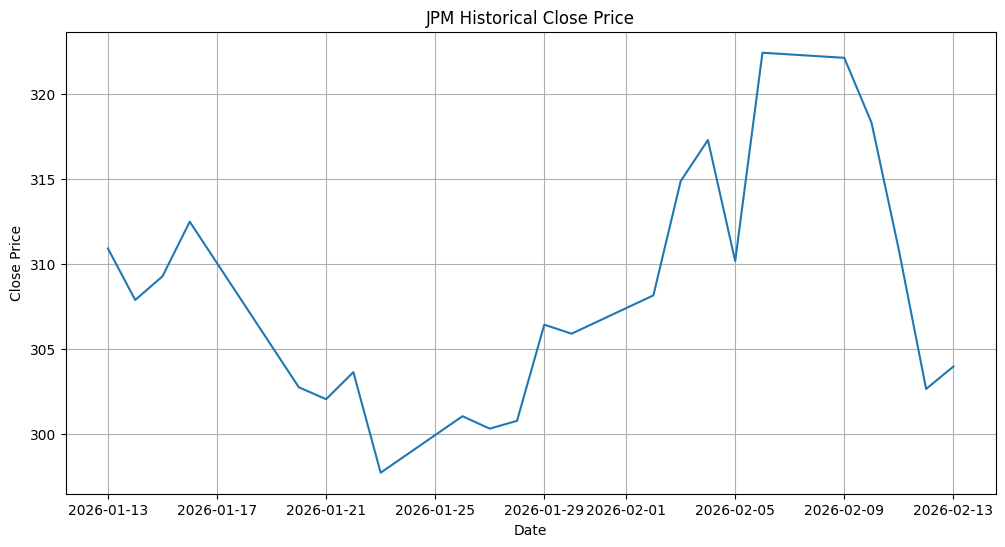

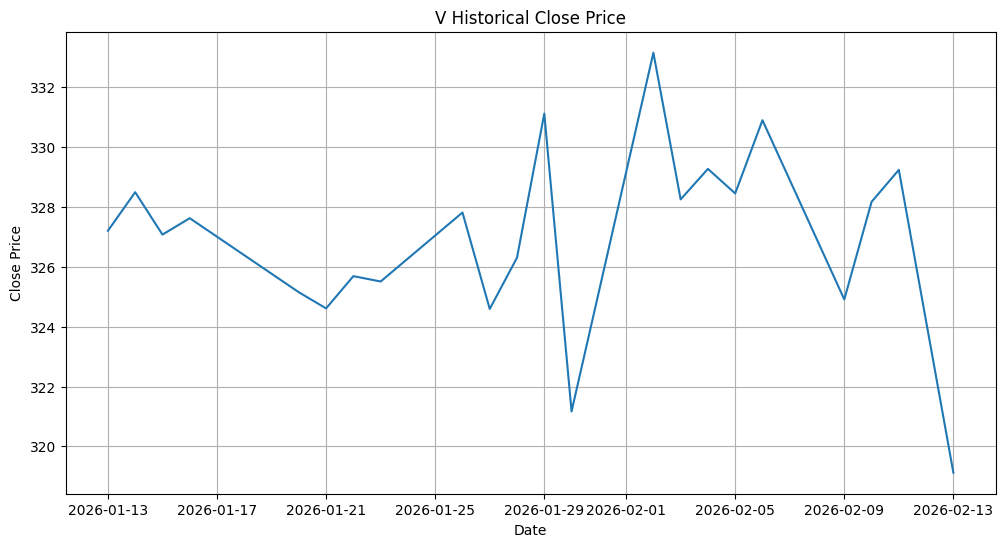

In [77]:
import matplotlib.pyplot as plt

# Check if all_symbols_data is available and not empty
if 'all_symbols_data' in globals() and all_symbols_data:
    for item in all_symbols_data:
        symbol = item['symbol']
        pdf_data = item['data']

        if not pdf_data.empty:
            plt.figure(figsize=(12, 6))
            plt.plot(pd.to_datetime(pdf_data['timestamp']), pdf_data['close'])
            plt.title(f'{symbol} Historical Close Price')
            plt.xlabel('Date')
            plt.ylabel('Close Price')
            plt.grid(True)
            plt.show()
        else:
            print(f"No data available to plot for {symbol}.")
else:
    print("No data available in all_symbols_data to plot. Please ensure the previous cell ran successfully and fetched data.")